# GRU

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna
import joblib
from torch.nn import GRU
import matplotlib.pyplot as plt

/Users/danielzellner/Documents/Studium/Bachelorthesis/torch_tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
experiment_log = pd.DataFrame(columns=["Epochen", "Hidden_Size", "Num_Layers", "Final_Loss", "Learning_Rate", "MAE", "RMSE", "sMAPE", "MAE Original", "RMSE Original", "sMAPE Original"])

In [2]:
df = pd.read_pickle('df_neutor_features.pkl')

In [3]:
# Gesamtdatenmenge
data_size = len(df)

# Aufteilung in Trainings-, Validierungs- und Testsets
train_size = int(data_size * 0.7)  # 70% Training
test_size = int(data_size * 0.2)   # 20% Test
val_size = data_size - train_size - test_size  # Rest für die Validierung

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]
val_data = df.iloc[train_size+test_size:]

In [4]:
def preprocess_data(data):
    X = data.drop(columns=["Neutor (gesamt)"])
    y = data["Neutor (gesamt)"]
    
    # "Zeit"-Spalte in datetime konvertieren
    X['Zeit'] = pd.to_datetime(X['Zeit'], format='%H:%M:%S')
    
    # Stunde und Minute extrahieren
    X['Stunde'] = X['Zeit'].dt.hour
    X['Minute'] = X['Zeit'].dt.minute
    
    # Datum zerlegen
    X['Jahr'] = X['Datum'].dt.year
    X['Monat'] = X['Datum'].dt.month
    X['Tag'] = X['Datum'].dt.day

    # One-Hot-Encoding für "Wochentag"
    X = pd.get_dummies(X, columns=['Wochentag'])
    X = pd.get_dummies(X, columns=['Jahreszeit'])

    # "Zeit" und "Datum" entfernen
    X = X.drop(columns=['Zeit', 'Datum'])

    return X, y

In [5]:
X_train, y_train = preprocess_data(train_data)
X_val, y_val = preprocess_data(val_data)
X_test, y_test = preprocess_data(test_data)

In [6]:
all_seasons = set(X_train.columns)
missing_seasons_val = all_seasons - set(X_val.columns)
missing_seasons_test = all_seasons - set(X_test.columns)

for season in missing_seasons_val:
    X_val[season] = False

for season in missing_seasons_test:
    X_test[season] = False

In [7]:
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

In [8]:
# Merkmale und Zielvariable skalieren
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [52]:
joblib.dump(scaler_X, 'scaler_gru/scaler_X_gru.pkl')
joblib.dump(scaler_y, 'scaler_gru/scaler_y_gru.pkl')

['scaler_gru/scaler_y_gru.pkl']

In [9]:
def create_sequences(data, target, sequence_length):
    sequences = []
    target_seq = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(seq)
        target_seq.append(label)
    
    return np.array(sequences), np.array(target_seq)

sequence_length = 10

X_train_sequence, y_train_sequence = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_sequence, y_test_sequence = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

In [10]:
X_train_sequence, y_train_sequence = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val_sequence, y_val_sequence = create_sequences(X_val_scaled, y_val_scaled, sequence_length)
X_test_sequence, y_test_sequence = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

In [11]:
X_train_tensor = torch.Tensor(X_train_sequence)
y_train_tensor = torch.Tensor(y_train_sequence)
X_val_tensor = torch.Tensor(X_val_sequence)
y_val_tensor = torch.Tensor(y_val_sequence)
X_test_tensor = torch.Tensor(X_test_sequence)
y_test_tensor = torch.Tensor(y_test_sequence)

In [47]:
# Setzen Seed
def set_seed(seed_value=42):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True

set_seed(42)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Definieren des GRU-Modells
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        output = self.linear(gru_out[:, -1, :])
        return output

input_size = X_train_tensor.shape[2] 

def objective(trial):
    # Hyperparameter-Räume
    hidden_size = trial.suggest_int("hidden_size", 30, 80)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.009, log=True)
    epochs = trial.suggest_int("epochs", 50, 150)  

    model = GRUModel(input_size, hidden_size, num_layers)
    criterion = nn.MSELoss() # <- Hier ist der Fehler, hätte MAE sein muessen
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Early Stopping 
    patience = 20
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs): 
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = mean_squared_error(y_val_tensor.numpy(), val_outputs.numpy())

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping after epoch {epoch}")
            break
    
    
    # Vorhersagen auf dem Testdatensatz
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predictions = predictions.numpy()
        y_test_np = y_test_tensor.numpy()

    # Metriken berechnen
    mae = np.mean(np.abs(predictions - y_test_np))
    rmse = np.sqrt(np.mean((predictions - y_test_np)**2))
    smape_met = smape(y_test_np, predictions)  

    # Vorhersagen zurücktransformieren
    predictions_original_scale = scaler_y.inverse_transform(predictions)
    y_test_original_scale = scaler_y.inverse_transform(y_test_np)

    # Metriken für zurücktransformierte Werte berechnen
    mae_original = np.mean(np.abs(predictions_original_scale - y_test_original_scale))
    rmse_original = np.sqrt(np.mean((predictions_original_scale - y_test_original_scale)**2))
    smape_original = smape(y_test_original_scale, predictions_original_scale)

    # Ergebnisse in den DataFrame speichern
    new_data = {
        "Epochen": trial.params["epochs"],
        "Hidden_Size": trial.params["hidden_size"],
        "Num_Layers": trial.params["num_layers"],
        "Final_Loss": val_loss,
        "Learning_Rate": trial.params["learning_rate"],
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": smape_met,
        "MAE Original": mae_original,
        "RMSE Original": rmse_original,
        "MAPE Original": smape_original
    }
    
    experiment_log.loc[len(experiment_log)] = new_data

    columns_to_round = ["Final_Loss", "MAE", "RMSE", "sMAPE", "MAE Original", "RMSE Original", "sMAPE Original"]
    
    return val_loss 

# Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

# Beste Hyperparameter ausgeben
print(study.best_params)


[I 2023-08-30 17:27:37,813] A new study created in memory with name: no-name-64c90a3f-994b-44cc-8c1a-b1920e57fc28
[I 2023-08-30 17:29:18,869] Trial 0 finished with value: 0.002282040426507592 and parameters: {'hidden_size': 60, 'num_layers': 2, 'learning_rate': 0.006901845512093896, 'epochs': 93}. Best is trial 0 with value: 0.002282040426507592.
[I 2023-08-30 17:30:45,569] Trial 1 finished with value: 0.001834232360124588 and parameters: {'hidden_size': 74, 'num_layers': 1, 'learning_rate': 0.00548414007546149, 'epochs': 140}. Best is trial 1 with value: 0.001834232360124588.
[I 2023-08-30 17:31:28,430] Trial 2 finished with value: 0.0022012817207723856 and parameters: {'hidden_size': 39, 'num_layers': 1, 'learning_rate': 0.005617501003748153, 'epochs': 125}. Best is trial 1 with value: 0.001834232360124588.
[I 2023-08-30 17:33:34,042] Trial 3 finished with value: 0.0016075746389105916 and parameters: {'hidden_size': 33, 'num_layers': 3, 'learning_rate': 0.005855842757714159, 'epochs'

Early stopping after epoch 121


[I 2023-08-30 17:53:59,571] Trial 12 finished with value: 0.00184398062992841 and parameters: {'hidden_size': 77, 'num_layers': 2, 'learning_rate': 0.005023650467716746, 'epochs': 130}. Best is trial 3 with value: 0.0016075746389105916.
[I 2023-08-30 17:57:17,005] Trial 13 finished with value: 0.001659278990700841 and parameters: {'hidden_size': 71, 'num_layers': 2, 'learning_rate': 0.00502257265341091, 'epochs': 150}. Best is trial 3 with value: 0.0016075746389105916.
[I 2023-08-30 17:58:22,889] Trial 14 finished with value: 0.002403220860287547 and parameters: {'hidden_size': 31, 'num_layers': 2, 'learning_rate': 0.0061697118679334365, 'epochs': 116}. Best is trial 3 with value: 0.0016075746389105916.
[I 2023-08-30 18:02:50,449] Trial 15 finished with value: 0.0016337152337655425 and parameters: {'hidden_size': 69, 'num_layers': 3, 'learning_rate': 0.005353620830812712, 'epochs': 135}. Best is trial 3 with value: 0.0016075746389105916.
[I 2023-08-30 18:05:50,409] Trial 16 finished wi

Early stopping after epoch 122


[I 2023-08-30 18:18:46,086] Trial 20 finished with value: 0.001702840905636549 and parameters: {'hidden_size': 68, 'num_layers': 3, 'learning_rate': 0.005372441579548648, 'epochs': 123}. Best is trial 3 with value: 0.0016075746389105916.
[I 2023-08-30 18:21:50,834] Trial 21 finished with value: 0.0015864361776039004 and parameters: {'hidden_size': 72, 'num_layers': 2, 'learning_rate': 0.0053453342573316, 'epochs': 149}. Best is trial 21 with value: 0.0015864361776039004.
[I 2023-08-30 18:24:52,563] Trial 22 finished with value: 0.002053785603493452 and parameters: {'hidden_size': 73, 'num_layers': 2, 'learning_rate': 0.005285430071295746, 'epochs': 140}. Best is trial 21 with value: 0.0015864361776039004.
[I 2023-08-30 18:28:03,557] Trial 23 finished with value: 0.0018247144762426615 and parameters: {'hidden_size': 80, 'num_layers': 2, 'learning_rate': 0.006015423103722212, 'epochs': 142}. Best is trial 21 with value: 0.0015864361776039004.
[I 2023-08-30 18:31:57,380] Trial 24 finished

{'hidden_size': 78, 'num_layers': 1, 'learning_rate': 0.005446289975044725, 'epochs': 144}


In [48]:
print(study.best_params)
print(study.best_value)

{'hidden_size': 78, 'num_layers': 1, 'learning_rate': 0.005446289975044725, 'epochs': 144}
0.0015041799051687121


In [54]:
experiment_log

,Epochen,Hidden_Size,Num_Layers,Final_Loss,Learning_Rate,MAE,RMSE,sMAPE,MAE Original,RMSE Original,sMAPE Original
0,93,60,2,0.002282,0.006902,0.039059,0.053831,NaN,94.287651,129.948715,NaN
1,140,74,1,0.001834,0.005484,0.036649,0.049731,NaN,88.471207,120.050819,NaN
2,125,39,1,0.002201,0.005618,0.036396,0.050705,NaN,87.858765,122.401314,NaN
3,144,33,3,0.001608,0.005856,0.035301,0.049615,NaN,85.217384,119.770485,NaN
4,56,35,1,0.005230,0.006364,0.054103,0.070839,NaN,130.604996,171.005356,NaN
5,87,66,3,0.002644,0.006385,0.042534,0.057943,NaN,102.676559,139.874603,NaN
6,70,62,3,0.003218,0.008457,0.045032,0.060176,NaN,108.708305,145.265793,NaN
7,147,56,3,0.001867,0.005703,0.036230,0.050096,NaN,87.458641,120.932442,NaN
8,91,57,2,0.002809,0.005852,0.041309,0.056260,NaN,99.719688,135.812332,NaN
9,103,49,1,0.002751,0.005670,0.041169,0.056114,NaN,99.382828,135.458923,NaN


In [53]:
experiment_log.to_csv('model_metadata/experiment_log_gru.csv', index=False)

In [13]:
# Definieren des GRU-Modells
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        output = self.linear(gru_out[:, -1, :])
        return output

input_size = X_train_tensor.shape[2]

# Beste Hyperparameter aus Optuna
#best_params = study.best_params
hidden_size_opt =  best_params["hidden_size"]
num_layers_opt =  best_params["num_layers"]
learning_rate_opt = best_params["learning_rate"]
epochs_opt = best_params["epochs"]

# Modellinstanz erzeugen
model = GRUModel(input_size, hidden_size_opt, num_layers_opt)

# Verlustfunktion und Optimierer
criterion = nn.MSELoss() # <- Hier ist der Fehler, hätte MAE sein muessen
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_opt)

# Training und Validierungsverlust
train_losses = []
val_losses = []

# Training
for epoch in range(epochs_opt):
    # Vorwärtslauf
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Rückwärtslauf und Optimierung
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Trainingsverlust speichern
    train_losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs_opt}, Loss: {loss.item()}")

    # Validierung
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Validierungsverlust speichern
    val_losses.append(val_loss.item())

Epoch 0/144, Loss: 0.0401841439306736
Epoch 10/144, Loss: 0.01761460490524769
Epoch 20/144, Loss: 0.009163348004221916
Epoch 30/144, Loss: 0.007057950831949711
Epoch 40/144, Loss: 0.0061263772659003735
Epoch 50/144, Loss: 0.00473500182852149
Epoch 60/144, Loss: 0.00392953073605895
Epoch 70/144, Loss: 0.003297096583992243
Epoch 80/144, Loss: 0.0028247421141713858
Epoch 90/144, Loss: 0.0024193590506911278
Epoch 100/144, Loss: 0.0020947828888893127
Epoch 110/144, Loss: 0.001831608940847218
Epoch 120/144, Loss: 0.0016184980049729347
Epoch 130/144, Loss: 0.0014574633678421378
Epoch 140/144, Loss: 0.0018463695887476206


In [55]:
df_best_params = pd.DataFrame([best_params])

# Speichern Sie den DataFrame in einer CSV-Datei
df_best_params.to_csv('model_metadata/best_params_gru.csv', index=False)

In [56]:
df_best_params

,hidden_size,num_layers,learning_rate,epochs
0,78,1,0.005446,144


In [50]:
# Vorhersagen auf dem Testdatensatz
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = predictions.numpy()
    y_test_np = y_test_tensor.numpy()


mae = np.mean(np.abs(predictions - y_test_np))
rmse = np.sqrt(np.mean((predictions - y_test_np)**2))
smape_met = smape(y_test_np, predictions)  

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {smape_met}%")

# Vorhersagen zurücktransformieren
predictions_original_scale = scaler_y.inverse_transform(predictions)

# Tatsächliche Werte zurücktransformieren
y_test_original_scale = scaler_y.inverse_transform(y_test_np)

# Jetzt berechnen Sie die Metriken erneut mit den zurücktransformierten Werten
mae_original = np.mean(np.abs(predictions_original_scale - y_test_original_scale))
rmse_original = np.sqrt(np.mean((predictions_original_scale - y_test_original_scale)**2))
smape_original = smape(y_test_original_scale, predictions_original_scale)

print(f"Mean Absolute Error (MAE Original): {mae_original}")
print(f"Root Mean Squared Error (RMSE Original): {rmse_original}")
print(f"Mean Absolute Percentage Error (MAPE Original): {smape_original}%")

Mean Absolute Error (MAE): 0.0352812185883522
Root Mean Squared Error (RMSE): 0.04944876208901405
Mean Absolute Percentage Error (MAPE): 36.36583605703357%
Mean Absolute Error (MAE Original): 85.16885375976562
Root Mean Squared Error (RMSE Original): 119.36930847167969
Mean Absolute Percentage Error (MAPE Original): 36.36583605703357%


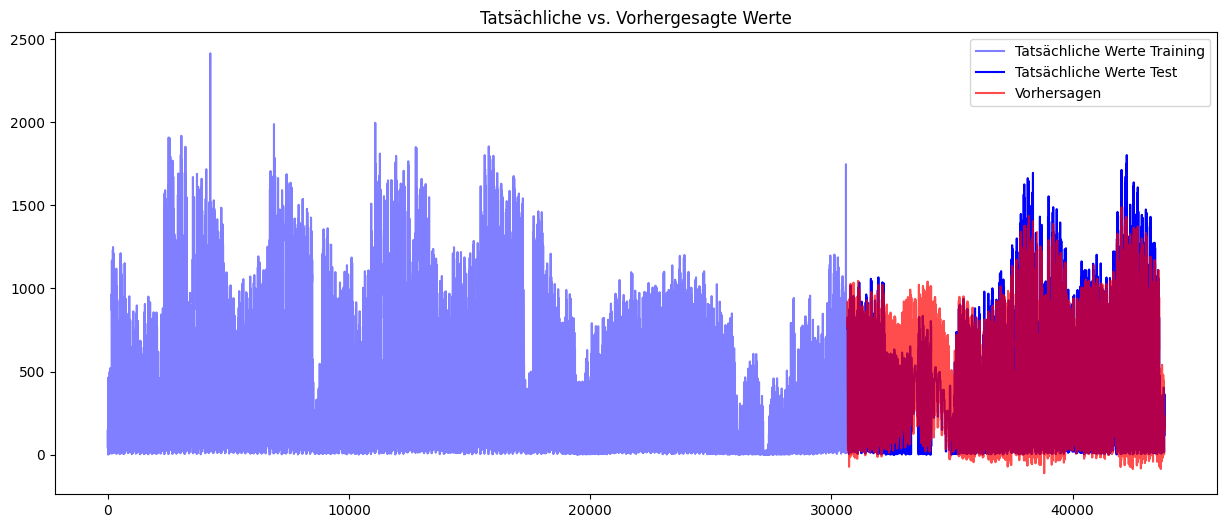

In [51]:
import matplotlib.pyplot as plt

# Vorhersagen mit dem Modell
y_pred = model(X_test_tensor)
y_pred = y_pred.detach().numpy()

# Rücktransformation der Daten in den Originalmaßstab
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy())
y_train_original = scaler_y.inverse_transform(y_train_tensor.numpy())

# Visualisierung
plt.figure(figsize=(15, 6))

# Trainingsdaten in hellblau
plt.plot(y_train_original, label='Tatsächliche Werte Training', color='blue', alpha=0.5)

# Testdaten in dunkelblau
plt.plot(range(len(y_train_original) + sequence_length, len(y_train_original) + sequence_length + len(y_test_original)), y_test_original, label='Tatsächliche Werte Test', color='blue')

# Vorhersagen in rot
plt.plot(range(len(y_train_original) + sequence_length, len(y_train_original) + sequence_length + len(y_test_original)), y_pred_original, label='Vorhersagen', color='red', alpha=0.7)

plt.title('Tatsächliche vs. Vorhergesagte Werte')
plt.legend()
plt.show()

In [57]:
torch.save(model.state_dict(), 'gru_model_without_weather.pth')

### Overfitting test

[0.0401841439306736, 0.09586459398269653, 0.03143271058797836, 0.01966235786676407, 0.032658521085977554, 0.03223762288689613, 0.0217243954539299, 0.013277659192681313, 0.011675511486828327, 0.014843395911157131, 0.01761460490524769, 0.016896653920412064, 0.013705295510590076, 0.010599035769701004, 0.009160825051367283, 0.009446380659937859, 0.01054196897894144, 0.011360486969351768, 0.011278249323368073, 0.010364157147705555, 0.009163348004221916, 0.008276385255157948, 0.008017810061573982, 0.008294402621686459, 0.008717937394976616, 0.008877995423972607, 0.008602521382272243, 0.008025916293263435, 0.007444104179739952, 0.007101275958120823, 0.007057950831949711, 0.0071914526633918285, 0.007297272328287363, 0.00722179189324379, 0.006948914844542742, 0.006592241581529379, 0.0063062249682843685, 0.006180671975016594, 0.006186941172927618, 0.006207399535924196, 0.0061263772659003735, 0.005916961934417486, 0.005656956695020199, 0.005460972897708416, 0.005383150186389685, 0.005370925180613

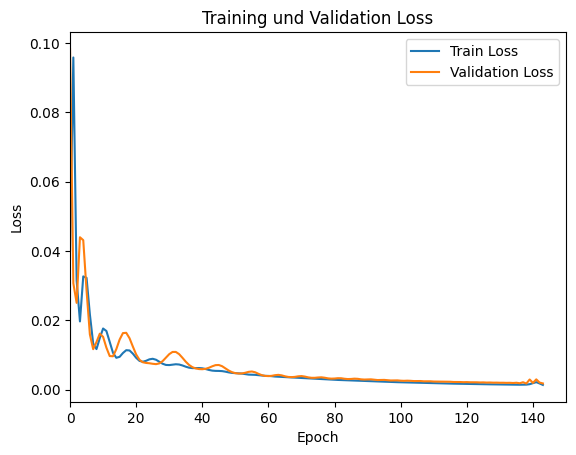

In [15]:
print(train_losses)
print(val_losses)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training und Validation Loss')
plt.legend()
plt.xlim(0, 150)

plt.savefig('visualization/mae_loss_gru.png', bbox_inches='tight', dpi=1000)

plt.show()